In [2]:
import numpy as np
import torch
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader

from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from ssapp import Utils

import seaborn as sns
sns.set_theme()
torch.manual_seed(42)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2


dataset = PatchAntennaDataset()

train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)


train_loader = DataLoader(train_data,batch_size=len(train_data),shuffle=True)
test_loader = DataLoader(test_data,batch_size=len(test_data),shuffle=True)


TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(test_loader))


pca = PCA(n_components=2)


pca_results = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))

(240, 3)
(240, 2)
Iteration 1, loss = 38.30093019
Iteration 2, loss = 37.01649227
Iteration 3, loss = 35.96281852
Iteration 4, loss = 34.77936764
Iteration 5, loss = 33.40866850
Iteration 6, loss = 31.88705912
Iteration 7, loss = 30.25744463
Iteration 8, loss = 28.64638904
Iteration 9, loss = 27.00161441
Iteration 10, loss = 25.73565554
Iteration 11, loss = 24.79251635
Iteration 12, loss = 24.56568128
Iteration 13, loss = 24.56440937
Iteration 14, loss = 24.48760262
Iteration 15, loss = 24.30592408
Iteration 16, loss = 23.69178041
Iteration 17, loss = 23.47658508
Iteration 18, loss = 23.26734994
Iteration 19, loss = 23.07850670
Iteration 20, loss = 22.93775577
Iteration 21, loss = 22.68495989
Iteration 22, loss = 22.38944779
Iteration 23, loss = 22.00612086
Iteration 24, loss = 21.82577077
Iteration 25, loss = 21.59901991
Iteration 26, loss = 21.37658360
Iteration 27, loss = 20.98107592
Iteration 28, loss = 20.73565491
Iteration 29, loss = 20.56733218
Iteration 30, loss = 20.49363759
I

/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


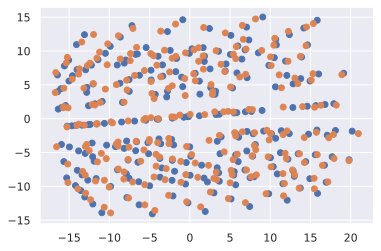

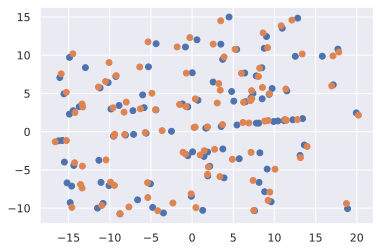

In [3]:
plt.figure()
plt.scatter(pca_results[:,0],pca_results[:,1])


pca_test = pca.transform(TEST_FIELDS.reshape((len(test_data),-1)))


X_train = TRAIN_PARAMS.numpy()
y_train = pca_results
print(X_train.shape)
print(y_train.shape)
clf = MLPRegressor(hidden_layer_sizes=(100,200,200,100),
                max_iter=800,verbose = True,
                early_stopping = False,
                n_iter_no_change = 200,
                learning_rate_init = 1e-3)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

plt.scatter(clf.predict(TRAIN_PARAMS)[:,0],clf.predict(TRAIN_PARAMS)[:,1])



plt.figure()
plt.scatter(pca_test[:,0],pca_test[:,1])
plt.scatter(clf.predict(TEST_PARAMS)[:,0],clf.predict(TEST_PARAMS)[:,1])



0.9999855511840681


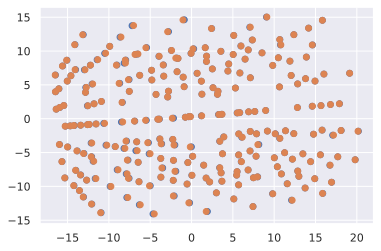

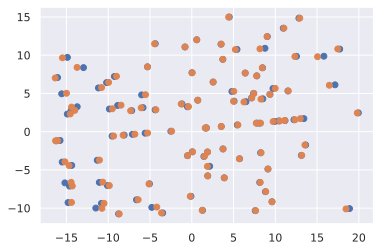

In [4]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

def pca_encode_decode(pca,field):
    field_shape = field.shape
    latent_space = pca.transform(field.reshape(field_shape[0],-1))
    reconstructed = pca.inverse_transform(latent_space)
    return reconstructed.reshape(field_shape)

pca = PCA(n_components=2)


pca_results = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
pca_test = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))

gpr = GaussianProcessRegressor().fit(X_train, y_train) 
print(gpr.score(X_train, y_train))
    

plt.figure()
plt.scatter(pca_results[:,0],pca_results[:,1])
plt.scatter(gpr.predict(TRAIN_PARAMS)[:,0],gpr.predict(TRAIN_PARAMS)[:,1])

plt.figure()
plt.scatter(pca_test[:,0],pca_test[:,1])
plt.scatter(gpr.predict(TEST_PARAMS)[:,0],gpr.predict(TEST_PARAMS)[:,1])
                        


Variance Exaplined [0.61024496 0.34696722]


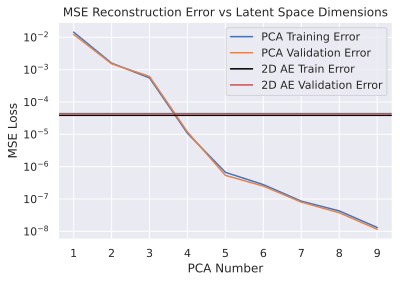

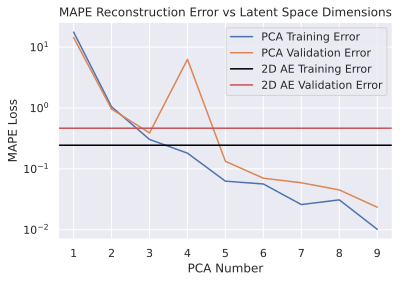

In [5]:

from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.models.HelperFunctions import loadModel
from sklearn import metrics

DEFAULT_CONFIG = {
    "learning_rate": 4e-4,
    "epochs": 20000,
    "batch_size": 1,
    "latent_size": 2,
    "number_cuts" : 343,
    "random_seed" : 42,
    'coder_channel_1': 11,
    'coder_channel_2': 60,
    'cuts': 343}

PCA_NUM = 2
model = loadModel(PatchAntenna1ConvAutoEncoder(config = DEFAULT_CONFIG),'treasured-haze-99') # Good 2-dimensional latent space
model.eval()
pca = PCA(n_components=PCA_NUM)
pca_results = pca.fit_transform(TRAIN_FIELDS.reshape((len(TRAIN_FIELDS),-1)))
print('Variance Exaplined',pca.explained_variance_ratio_)
idx = np.random.randint(0,103)

autoenc_pred_TEST = model(TEST_FIELDS[idx,::].float())
autoenc_pred_TRAIN = model(TRAIN_FIELDS[idx,::].float())

def plotAEvsPCA(AEmodel,train_fields, test_fields,pca_num = 2,idx = None):

    if idx is None:
        idx = np.random.randint(0,len(test_fields))


    pca = PCA(n_components=pca_num)
    pca.fit_transform(train_fields.reshape((len(train_fields),-1)))

    fig,axs = plt.subplots(nrows = 3, ncols = 1,figsize = (10,11))
    axs[0].set_title('True Field')
    axs[0].plot(test_fields[idx,:,:,1])
    axs[0].grid(True)
    axs[1].set_title('Latent-2D Autoencoder Reconstruction')
    axs[1].plot(autoenc_pred_TEST.detach()[0,:,:,1])
    axs[1].grid(True)
    axs[2].set_title('PCA-'+str(pca_num)+'D Reconstruction')
    axs[2].plot(pca_encode_decode(pca,test_fields[idx:idx+1,::])[0,:,:,1])
    axs[2].grid(True)

AE_rec_train_error = []
AE_rec_test_error = []
AE_MAPE_rec_train_error = []
AE_MAPE_rec_test_error = []
for i in range(0,len(TRAIN_FIELDS)):
    AE_rec_train_error.append(metrics.mean_squared_error(model(TRAIN_FIELDS[idx,::].float()).detach().flatten(),TRAIN_FIELDS[idx,::].numpy().flatten()))
    AE_MAPE_rec_train_error.append(metrics.mean_absolute_percentage_error(model(TRAIN_FIELDS[idx,::].float()).detach().flatten(),TRAIN_FIELDS[idx,::].numpy().flatten()))


for i in range(0,len(TEST_FIELDS)):
    AE_rec_test_error.append(metrics.mean_squared_error(model(TEST_FIELDS[idx,::].float()).detach().flatten(),TEST_FIELDS[idx,::].numpy().flatten()))
    AE_MAPE_rec_test_error.append(metrics.mean_absolute_percentage_error(model(TEST_FIELDS[idx,::].float()).detach().flatten(),TEST_FIELDS[idx,::].numpy().flatten()))

AE_rec_train_error = np.array(sum(AE_rec_train_error))/len(TRAIN_FIELDS)
AE_rec_test_error = np.array(sum(AE_rec_test_error))/len(TEST_FIELDS)

AE_MAPE_rec_train_error = np.array(sum(AE_MAPE_rec_train_error))/len(TRAIN_FIELDS)
AE_MAPE_rec_test_error = np.array(sum(AE_MAPE_rec_test_error))/len(TEST_FIELDS)

recon_train_error = []
recon_valid_error = []


for number_pca in range(1,10):
    pca = PCA(n_components=number_pca)
    pca_results = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))

    recon_train_error.append(metrics.mean_squared_error(pca_encode_decode(pca,TRAIN_FIELDS).flatten(),TRAIN_FIELDS.flatten()))
    recon_valid_error.append(metrics.mean_squared_error(pca_encode_decode(pca,TEST_FIELDS).flatten(),TEST_FIELDS.flatten()))



plt.figure()
plt.title('MSE Reconstruction Error vs Latent Space Dimensions')
plt.grid(True)
plt.semilogy(list( range(1,10)),recon_train_error,label = 'PCA Training Error')
plt.semilogy(list( range(1,10)),recon_valid_error,label = 'PCA Validation Error')
plt.axhline(AE_rec_train_error, label = '2D AE Train Error',c = 'black')
plt.axhline(AE_rec_test_error, label = '2D AE Validation Error',c = 'r')

plt.xlabel('PCA Number')
plt.ylabel('MSE Loss')
plt.legend()


MAPE_recon_train_error = []
MAPE_recon_valid_error = []
for number_pca in range(1,10):
    pca = PCA(n_components=number_pca)
    pca_results = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))

    MAPE_recon_train_error.append(metrics.mean_absolute_percentage_error(pca_encode_decode(pca,TRAIN_FIELDS).flatten(),TRAIN_FIELDS.flatten()))
    MAPE_recon_valid_error.append(metrics.mean_absolute_percentage_error(pca_encode_decode(pca,TEST_FIELDS).flatten(),TEST_FIELDS.flatten()))

plt.figure()
plt.title('MAPE Reconstruction Error vs Latent Space Dimensions')
plt.grid(True)
plt.semilogy(list( range(1,10)),MAPE_recon_train_error,label = 'PCA Training Error')
plt.semilogy(list( range(1,10)),MAPE_recon_valid_error,label = 'PCA Validation Error')
plt.axhline(AE_MAPE_rec_train_error,label = '2D AE Training Error',c = 'black')
plt.axhline(AE_MAPE_rec_test_error,label = '2D AE Validation Error',c = 'r')


plt.xlabel('PCA Number')
plt.ylabel('MAPE Loss')
plt.legend()

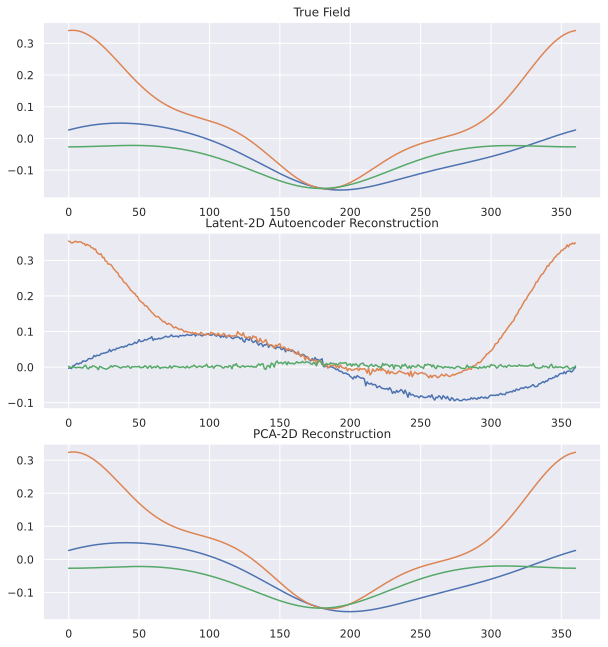

In [6]:
plotAEvsPCA(model,TRAIN_FIELDS,TEST_FIELDS,pca_num = 2)